$$D(x)=Wx+b$$
$$\mathcal L=\|D(x+\sigma z)-x\|^2$$
$$W,b=\arg\min_{W,b}\mathcal L$$

In [ ]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

### Analytical solution for empirical

In [112]:
W_init = th.randn(n_dim, n_dim).to(device) / math.sqrt(n_dim)
# assume we got it from above
# dev_k = (W_star_solu - W_init).pow(2).mean().sqrt()
V0 = (W_init @ U) # (n_dim, n_dim)
V_optim = U * (Lambda / (Lambda + sigma ** 2))[None, :] # (n_dim, n_dim)
delta_k = (V_optim - V0).pow(2).mean(dim=0) # (n_dim, ) # not sure it's sum or mean
delta_k_weighted = delta_k * (Lambda + sigma ** 2) # (n_dim, )

eta = 0.1
t_vec = th.logspace(-3, 2, 1000).to(device) # (n_time, )
exp_fun = th.exp(-4 * eta * t_vec[:, None] * (Lambda + sigma ** 2)[None, :]) # (n_time, n_dim)
loss_theory = exp_fun @ delta_k_weighted # (n_time, )

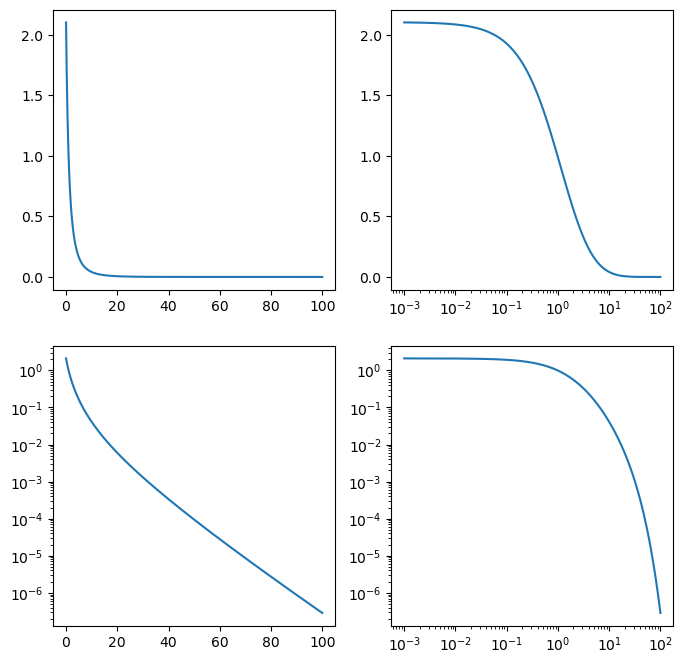

In [127]:
figh, axs = plt.subplots(2,2,figsize=(8, 8))
axs = axs.flatten()
for i, plot_fun in enumerate([plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(axs[i])
    plot_fun(t_vec.cpu().numpy(), loss_theory.cpu().numpy())
plt.show()

### Analytical theory learning curve

In [5]:
import torch
def symmetric_learning_solu_scaling(t, lambda_k, sigma, q_k_0_norm, eta=1,):
    # Ensure inputs are tensors for PyTorch operations
    t = torch.tensor(t, dtype=torch.float32)
    lambda_k = torch.tensor(lambda_k, dtype=torch.float32)
    sigma = torch.tensor(sigma, dtype=torch.float32)
    eta = torch.tensor(eta, dtype=torch.float32)
    q_k_0_norm = torch.tensor(q_k_0_norm, dtype=torch.float32)
    

    # Calculate the expression step by step
    term1 = torch.sqrt(lambda_k / (sigma**2 + lambda_k))
    exp_term = torch.exp(-8 * eta * lambda_k * t)
    denominator = torch.sqrt((lambda_k / (sigma**2 + lambda_k)) * exp_term + (1 - exp_term) * q_k_0_norm**2)
    result = (term1 / denominator) * q_k_0_norm
    return result


def symmetric_learning_loss(t, lambda_k, sigma, q_k_0_norm, eta=1,):
    # Ensure inputs are tensors for PyTorch operations
    t = torch.tensor(t, dtype=torch.float32)
    lambda_k = torch.tensor(lambda_k, dtype=torch.float32)
    sigma = torch.tensor(sigma, dtype=torch.float32)
    eta = torch.tensor(eta, dtype=torch.float32)
    q_k_0_norm = torch.tensor(q_k_0_norm, dtype=torch.float32)
    
    # Calculate the expression step by step
    diff_term = lambda_k / (sigma**2 + lambda_k) - q_k_0_norm ** 2 
    exp_term = torch.exp(-8 * eta * lambda_k * t)
    nominator = diff_term * exp_term
    denominator = diff_term * exp_term + q_k_0_norm**2
    result = (nominator / denominator) ** 2
    return result


def symmetric_learning_loss_weighted(t, lambda_k, sigma, q_k_0_norm, eta=1,):
    # Ensure inputs are tensors for PyTorch operations
    loss_curv = symmetric_learning_loss(t, lambda_k, sigma, q_k_0_norm, eta)
    weight = lambda_k ** 2 / (sigma ** 2 + lambda_k)
    return loss_curv * weight

In [33]:
from circuit_toolkit.plot_utils import saveallforms
figdir = '/n/home12/binxuwang/Github/DiffusionLearningCurve/figures'

/tmp/ipykernel_1277740/2036613631.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


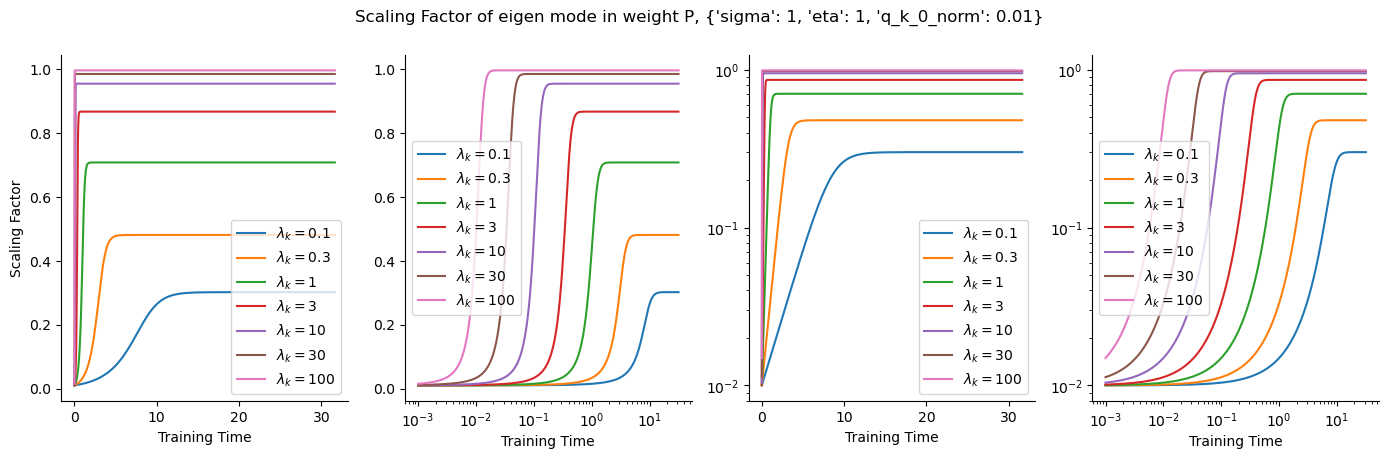

In [35]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=1, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Scaling Factor')
    plt.legend()
plt.suptitle(f'Scaling Factor of eigen mode in weight P, {parameters}')
saveallforms(figdir, f'symm_lrncrv_scaling_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_1277740/2036613631.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


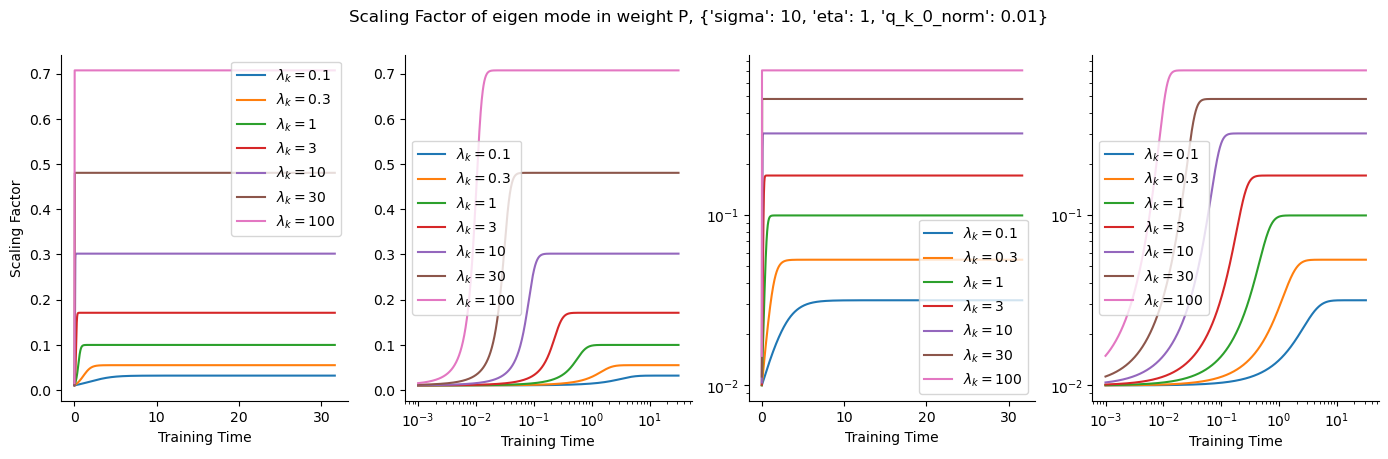

In [36]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=10, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Scaling Factor')
    plt.legend()
plt.suptitle(f'Scaling Factor of eigen mode in weight P, {parameters}')
saveallforms(figdir, f'symm_lrncrv_scaling_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_1277740/2036613631.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


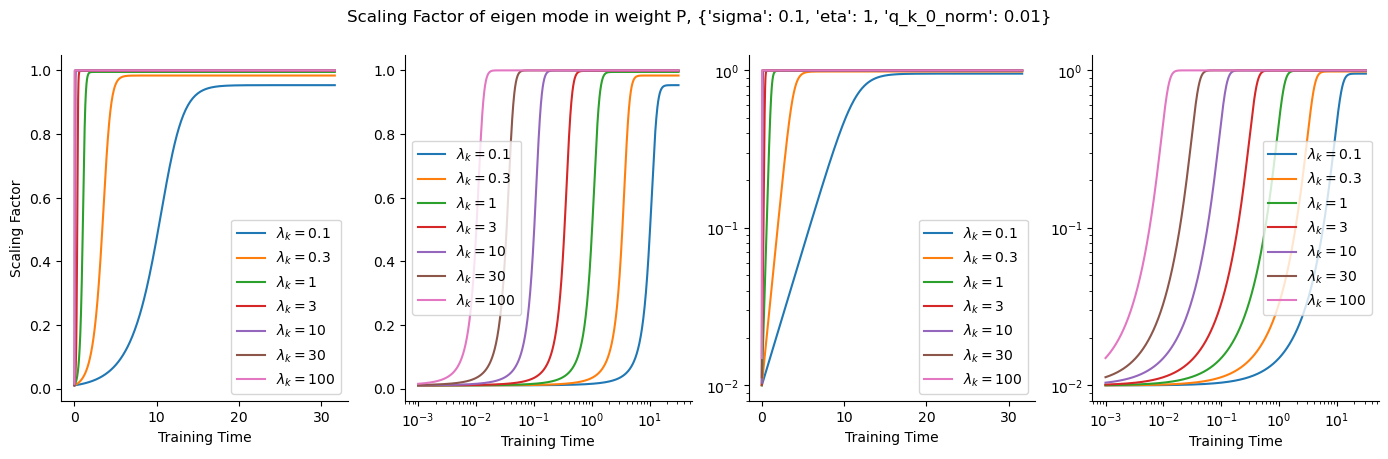

In [37]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=0.1, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    plt.xlabel('Training Time')
    if ax == axs[0]:
        plt.ylabel('Scaling Factor')
    plt.legend()
plt.suptitle(f'Scaling Factor of eigen mode in weight P, {parameters}')
saveallforms(figdir, f'symm_lrncrv_scaling_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_2443671/3011456134.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


Text(0, 0.5, 'Scaling Factor')

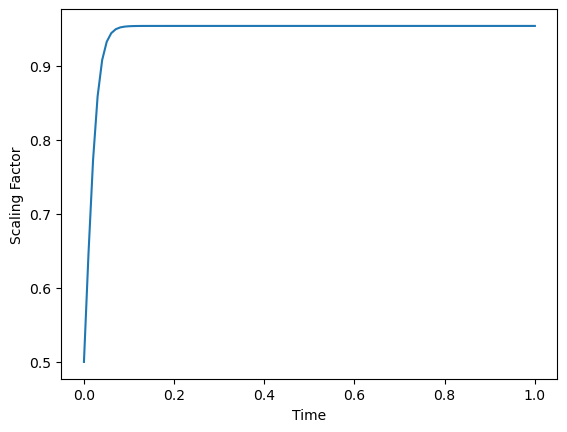

In [42]:
t_vec = torch.linspace(0, 1, 100)
scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=10, sigma=1, eta=1, q_k_0_norm=0.5)
plt.plot(t_vec, scaling_curve)
plt.xlabel('Time')
plt.ylabel('Scaling Factor')

/tmp/ipykernel_2443671/3011456134.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


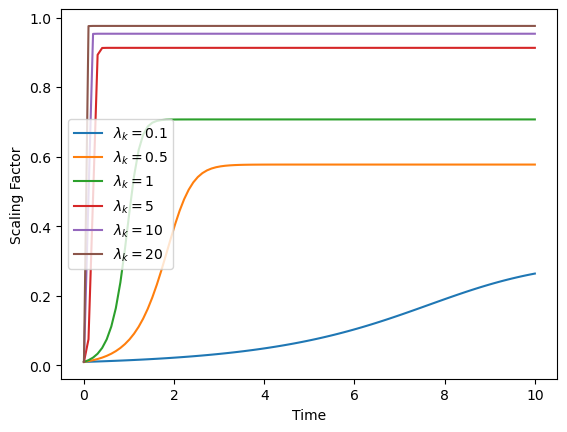

In [47]:
t_vec = torch.linspace(0, 10, 100)
for lambda_k in [0.1, 0.5, 1, 5, 10, 20]:
    scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.01)
    plt.plot(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Time')
plt.ylabel('Scaling Factor')
plt.legend()

/tmp/ipykernel_1277740/2036613631.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


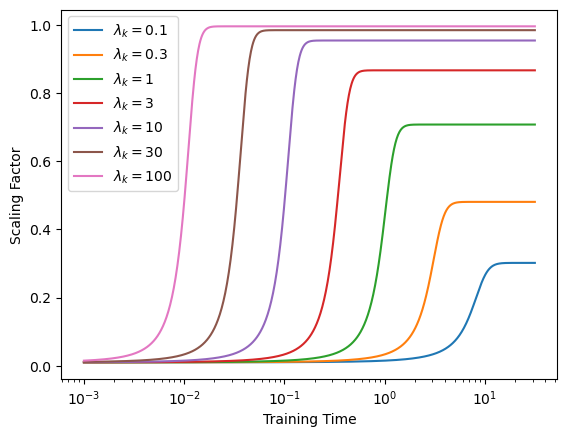

In [6]:
# t_vec = torch.linspace(0.001, 100, 1000)
t_vec = torch.logspace(-3, 1.5, 1000)
for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
    scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.01)
    plt.semilogx(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Training Time')
plt.ylabel('Scaling Factor')
plt.legend()

/tmp/ipykernel_2443671/3011456134.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


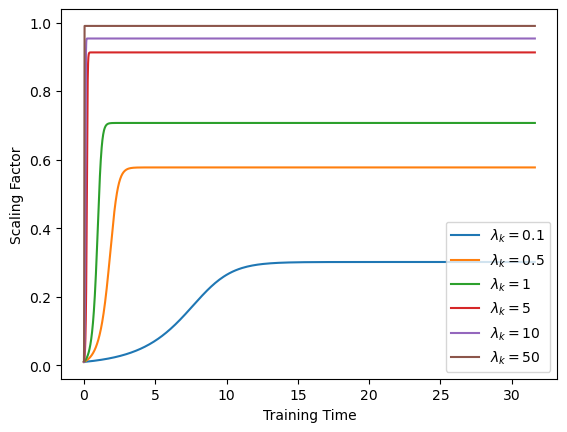

In [60]:
# t_vec = torch.linspace(0.001, 100, 1000)
t_vec = torch.logspace(-3, 1.5, 1000)
for lambda_k in [0.1, 0.5, 1, 5, 10, 50]:
    scaling_curve = symmetric_learning_solu_scaling(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.01)
    plt.plot(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Training Time')
plt.ylabel('Scaling Factor')
plt.legend()

/tmp/ipykernel_1277740/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


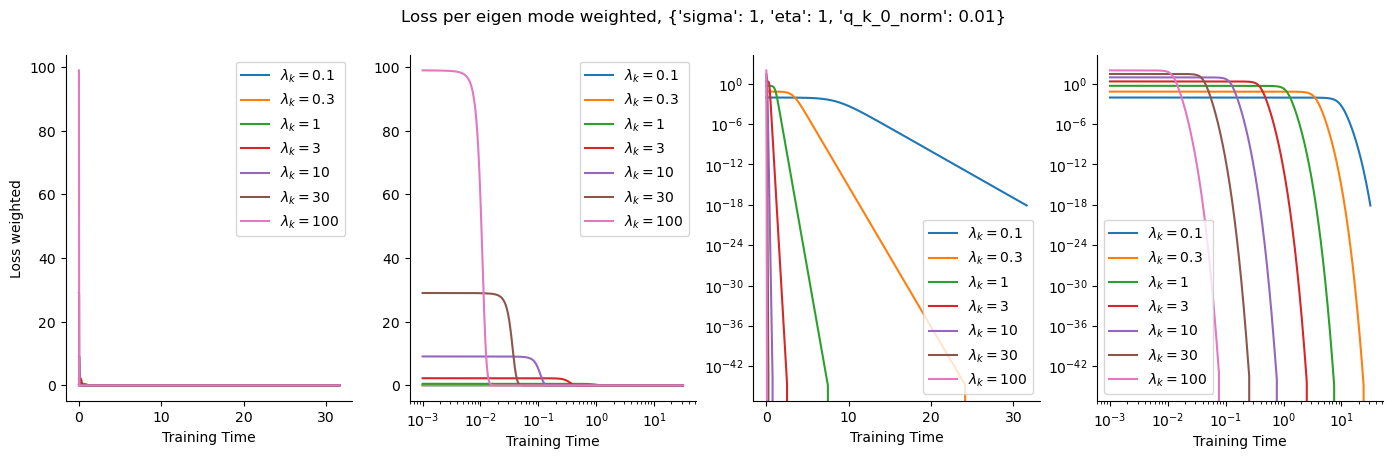

In [38]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=1, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_loss_weighted(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    if ax == axs[0]:
        plt.ylabel('Loss weighted')
    plt.xlabel('Training Time')
    plt.legend()
plt.suptitle(f'Loss per eigen mode weighted, {parameters}')
saveallforms(figdir, f'symm_lrncrv_loss_per_mode_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_1277740/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


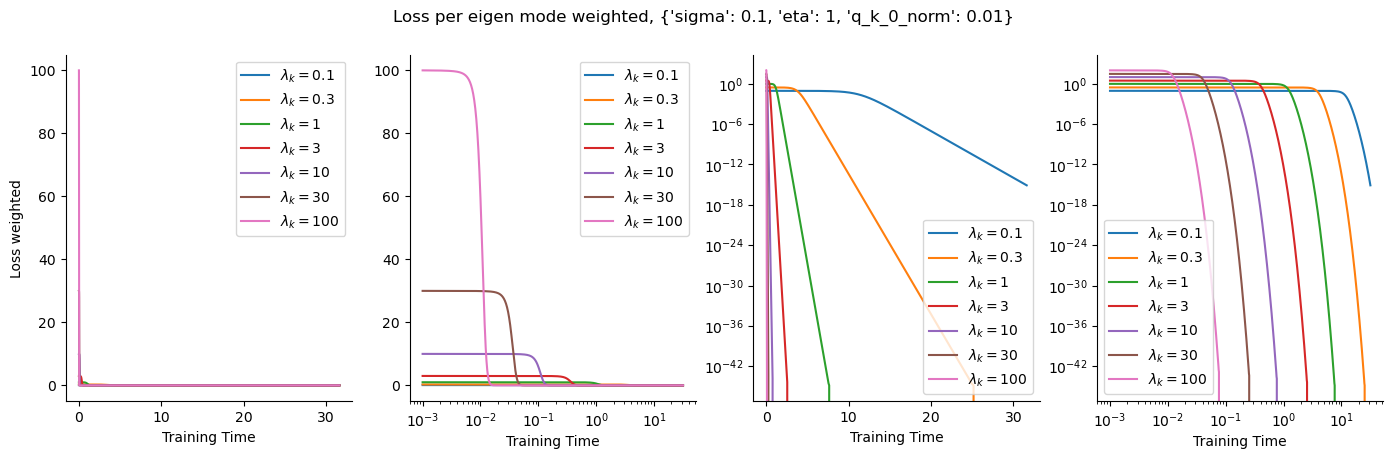

In [39]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=0.1, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_loss_weighted(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    if ax == axs[0]:
        plt.ylabel('Loss weighted')
    plt.xlabel('Training Time')
    plt.legend()
plt.suptitle(f'Loss per eigen mode weighted, {parameters}')
saveallforms(figdir, f'symm_lrncrv_loss_per_mode_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_1277740/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


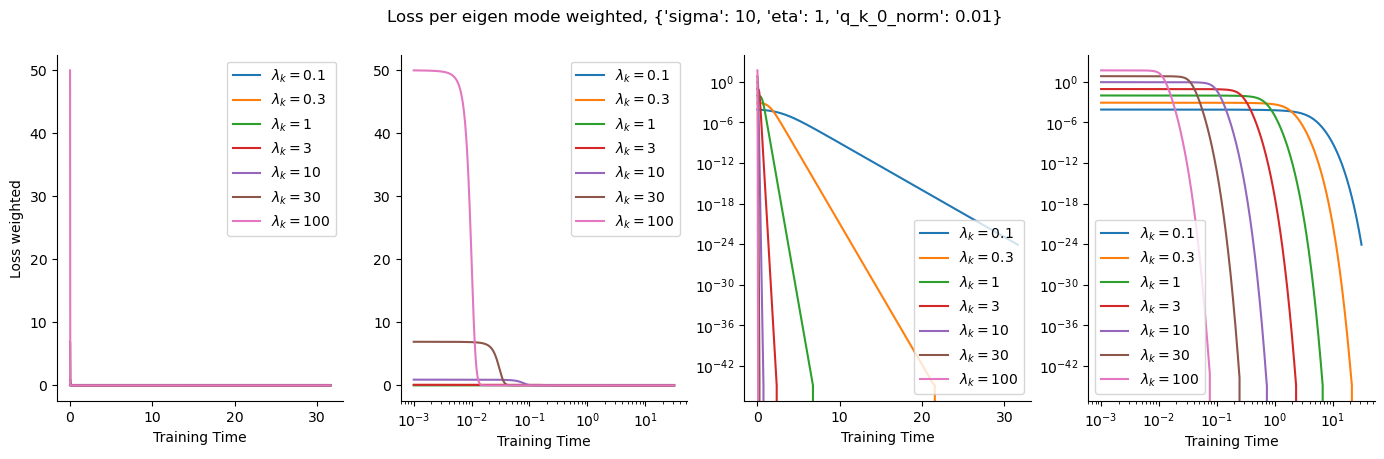

In [40]:
# t_vec = torch.linspace(0.001, 100, 1000)
parameters = dict(sigma=10, eta=1, q_k_0_norm=0.01)
t_vec = torch.logspace(-3, 1.5, 1000)
figh, axs = plt.subplots(1, 4, figsize=(17, 4.5))
for ax, plot_fun in zip(axs, [plt.plot, plt.semilogx, plt.semilogy, plt.loglog]):
    plt.sca(ax)
    for lambda_k in [0.1, 0.3, 1, 3, 10, 30, 100]:
        scaling_curve = symmetric_learning_loss_weighted(t_vec, lambda_k=lambda_k, **parameters)
        plot_fun(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$', )
    if ax == axs[0]:
        plt.ylabel('Loss weighted')
    plt.xlabel('Training Time')
    plt.legend()
plt.suptitle(f'Loss per eigen mode weighted, {parameters}')
saveallforms(figdir, f'symm_lrncrv_loss_per_mode_sigma{parameters["sigma"]:.1f}', figh)
plt.show()

/tmp/ipykernel_2443671/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


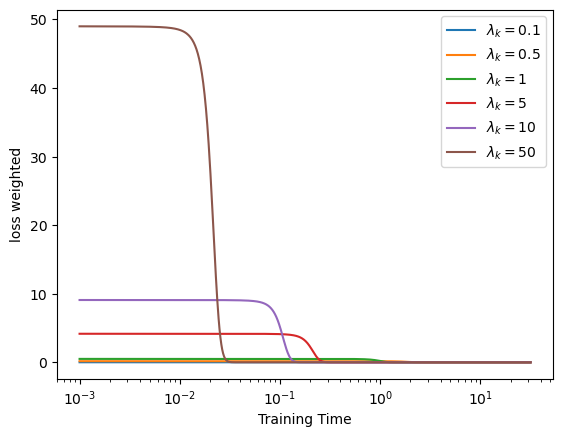

In [74]:
# t_vec = torch.linspace(0.001, 100, 1000)
t_vec = torch.logspace(-3, 1.5, 1000)
for lambda_k in [0.1, 0.5, 1, 5, 10, 50]:
    scaling_curve = symmetric_learning_loss_weighted(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.01)
    plt.semilogx(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Training Time')
plt.ylabel('loss weighted')
plt.legend()

/tmp/ipykernel_2443671/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


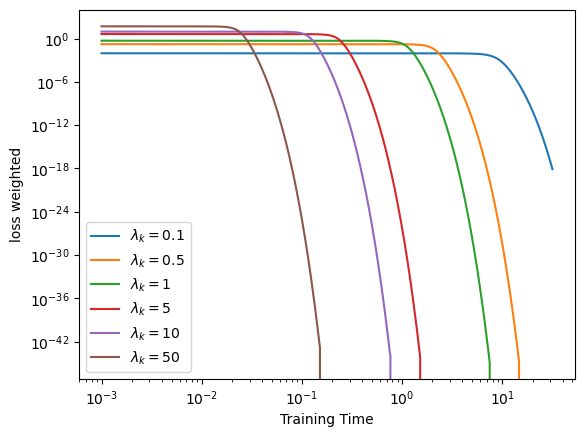

In [75]:
# t_vec = torch.linspace(0.001, 100, 1000)
t_vec = torch.logspace(-3, 1.5, 1000)
for lambda_k in [0.1, 0.5, 1, 5, 10, 50]:
    scaling_curve = symmetric_learning_loss_weighted(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.01)
    plt.loglog(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Training Time')
plt.ylabel('loss weighted')
plt.legend()

/tmp/ipykernel_2443671/2036613631.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


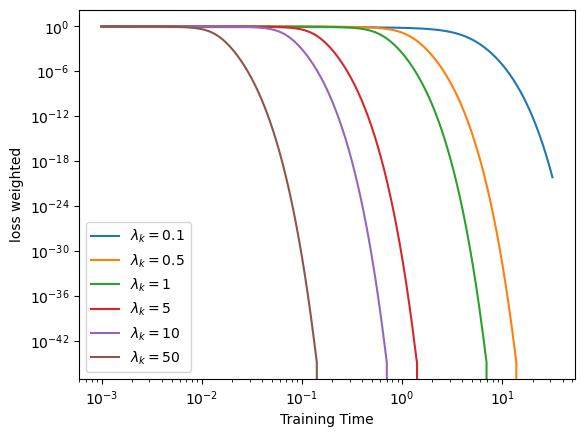

In [72]:
# t_vec = torch.linspace(0.001, 100, 1000)
t_vec = torch.logspace(-3, 1.5, 1000)
for lambda_k in [0.1, 0.5, 1, 5, 10, 50]:
    scaling_curve = symmetric_learning_loss(t_vec, lambda_k=lambda_k, sigma=1, eta=1, q_k_0_norm=0.1)
    plt.loglog(t_vec, scaling_curve, label=f'$\lambda_k = {lambda_k}$')
plt.xlabel('Training Time')
plt.ylabel('loss weighted')
plt.legend()